Investigate the glacier-sclae and regional-scale trend in dhdt etc...

In [1]:
import os
import rasterio as rio
import numpy as np
import shapely 
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_dc = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_dc_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(fp_dc).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")

# add the o3region as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["o3region","geometry"]])
dc_gdf = dc_gdf.sjoin(regions_gdf[["o3region","geometry"]])

In [5]:
# open the base data for each glacier, format into a single df
c=0
all_series = []
for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>10: continue
    
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    o3region = row['o3region']
    
    # if o1region!='15':continue
    # print progress
    # print(c, "of", len(rgi_gdf), rgi_id)
    if c%100==0: print(c, "of", len(rgi_gdf), rgi_id)

    # open glacier-specific cloud info as a pd.Series, append to list
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'base_info.csv')
    df_g = pd.read_csv(path_open, index_col=0, header=None).squeeze()
    df_g['o3_region'] = str(o3region)
    all_series.append(df_g)

# format into df
df_all = pd.DataFrame(all_series).reset_index(drop=True)


# format to numeric dtypes
all_cols = df_all.columns
for c in all_cols:
    if c in ['rgi_id', 'o1_region', 'o2_region']: continue
    df_all[c] = df_all[c].astype(float)

# merge with glacier area
print("All done!")

100 of 769 RGI2000-v7.0-G-14-06944
200 of 769 RGI2000-v7.0-G-13-71307
300 of 769 RGI2000-v7.0-G-14-15108
400 of 769 RGI2000-v7.0-G-14-32564
500 of 769 RGI2000-v7.0-G-15-01330
600 of 769 RGI2000-v7.0-G-15-05352
700 of 769 RGI2000-v7.0-G-15-08609
All done!


In [6]:
# craft a cmap for our regions
from matplotlib.colors import ListedColormap
colors_all = ["red","maroon","indianred","tomato","orangered",
             "goldenrod","darkkhaki","olive",
             "cornflowerblue","navy","blue"]
cmap_o2 = ListedColormap(colors_all)

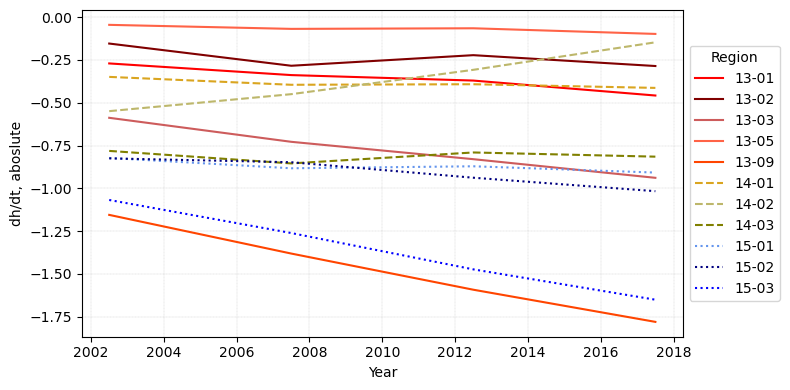

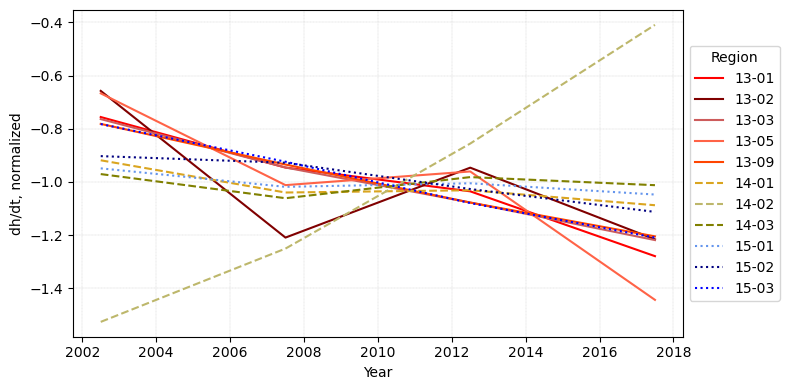

In [9]:
# lets plots the 02region average dhdt
df_o2 = df_all.groupby("o2_region").mean(numeric_only=True).reset_index()
cols = ["dhdt_0005_mean","dhdt_0510_mean","dhdt_1015_mean","dhdt_1520_mean"]
xs = [2002.5, 2007.5, 2012.5, 2017.5]

# start figure
fig,axs = plt.subplots(figsize=(8,4))

# plot each o2region separately
for idx,row in df_o2.iterrows():
    
    label = row['o2_region']
    if label[:2]=='13': linestyle='solid'
    elif label[:2]=='14': linestyle='dashed'
    elif label[:2]=='15': linestyle='dotted'
    
    data = row[cols].values
    norm = row["dhdt_0020_mean"]
    axs.plot(xs, data, c=colors_all[idx],
             linestyle=linestyle, label=label)
    
axs.set_xlabel('Year')
axs.set_ylabel('dh/dt, aboslute')
axs.legend(loc='center left', title='Region', bbox_to_anchor=(1,0.5))
axs.grid(linestyle='dashed', linewidth=0.2, zorder=1)
plt.tight_layout()

# start figure
fig,axs = plt.subplots(figsize=(8,4))

# plot each o2region separately
for idx,row in df_o2.iterrows():
    
    label = row['o2_region']
    if label[:2]=='13': linestyle='solid'
    elif label[:2]=='14': linestyle='dashed'
    elif label[:2]=='15': linestyle='dotted'
    
    data = row[cols].values
    norm = row["dhdt_0020_mean"]
    axs.plot(xs, (data)/abs(norm), c=colors_all[idx],
             linestyle=linestyle, label=label)
    
axs.set_xlabel('Year')
axs.set_ylabel('dh/dt, normalized')
axs.legend(loc='center left', title='Region', bbox_to_anchor=(1,0.5))
axs.grid(linestyle='dashed', linewidth=0.2, zorder=1)
plt.tight_layout()

Text(0, 0.5, 'dh/dt')

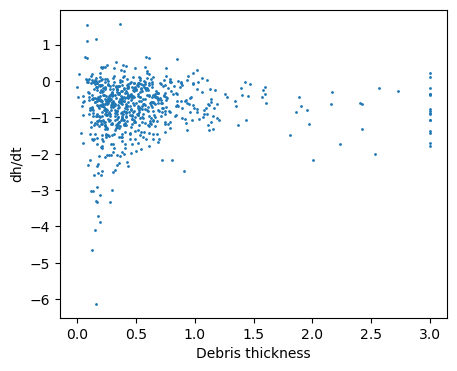

In [10]:
# scatterplot of debris thickness vs thinning rate
fig,axs = plt.subplots(figsize=(5,4))
axs.scatter(df_all['dte_med'], df_all['dhdt_0020_med'], s=1)
axs.set_xlabel("Debris thickness")
axs.set_ylabel("dh/dt")

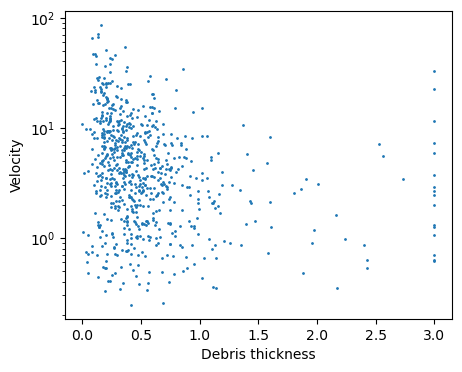

In [11]:
# scatterplot of debris thickness vs velocity
fig,axs = plt.subplots(figsize=(5,4))
axs.scatter(df_all['dte_med'], df_all['v_med'], s=1)
axs.set_xlabel("Debris thickness")
axs.set_ylabel("Velocity")
axs.set_yscale('log')

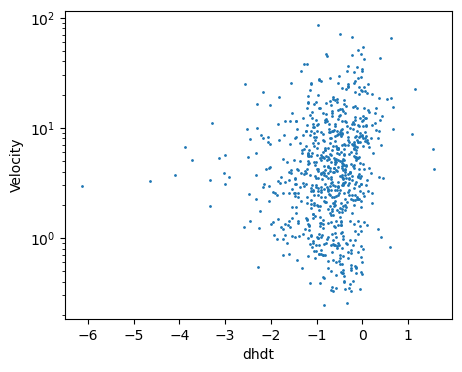

In [12]:
# scatterplot of dhdt vs velocity
fig,axs = plt.subplots(figsize=(5,4))
axs.scatter(df_all['dhdt_0020_med'], df_all['v_med'], s=1)
axs.set_xlabel("dhdt")
axs.set_ylabel("Velocity")
axs.set_yscale('log')
# axs.set_xscale('log')

In [13]:
df_all.columns

Index(['rgi_id', 'o1_region', 'o2_region', 'area_km2', 'dc_area_km2', 'z_mean',
       'z_med', 'z_min', 'z_max', 'z_25', 'z_75', 'v_mean', 'v_med', 'v_min',
       'v_max', 'v_25', 'v_75', 'dte_mean', 'dte_med', 'dte_min', 'dte_max',
       'dte_25', 'dte_75', 'dhdt_0005_mean', 'dhdt_0005_med', 'dhdt_0005_min',
       'dhdt_0005_max', 'dhdt_0005_25', 'dhdt_0005_75', 'dhdt_0010_mean',
       'dhdt_0010_med', 'dhdt_0010_min', 'dhdt_0010_max', 'dhdt_0010_25',
       'dhdt_0010_75', 'dhdt_0020_mean', 'dhdt_0020_med', 'dhdt_0020_min',
       'dhdt_0020_max', 'dhdt_0020_25', 'dhdt_0020_75', 'dhdt_0510_mean',
       'dhdt_0510_med', 'dhdt_0510_min', 'dhdt_0510_max', 'dhdt_0510_25',
       'dhdt_0510_75', 'dhdt_1015_mean', 'dhdt_1015_med', 'dhdt_1015_min',
       'dhdt_1015_max', 'dhdt_1015_25', 'dhdt_1015_75', 'dhdt_1020_mean',
       'dhdt_1020_med', 'dhdt_1020_min', 'dhdt_1020_max', 'dhdt_1020_25',
       'dhdt_1020_75', 'dhdt_1520_mean', 'dhdt_1520_med', 'dhdt_1520_min',
       'dhdt_1520